In [1]:
import pandas as pd
import numpy as np

In [93]:
df = pd.read_csv("cleaned_data.csv")
df.head()

/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,original text,cleaned text,joke
0,0,I am soooo glad I'm not circumcised! My corona...,soooo glad circumcised corona covered foreskin...,1.0
1,1,Did you know Google now has a platform for rec...,know google platform recording bowel movements...,1.0
2,2,What is the difference between my wife and my ...,difference wife vacuum vacuum nt snore sex amp...,1.0
3,3,What did the French man say to the attractive ...,french man say attractive teletubby oo lala,1.0
4,4,"Yo Mama Yo momma's so fat, that when she went ...",yo mama yo momma fat went zoo hippos got jealous,1.0


In [94]:
df = df.drop(columns=df.columns.values[0:2])

In [95]:
df = df.dropna()

In [97]:
df_jokes = df[df['joke']>0]
df_non_jokes = df[df['joke']<0]

In [102]:
df = pd.concat([df_jokes.sample(25000),
                df_non_jokes.sample(25000)])
df.head()

,cleaned text,joke
348792,like cheesy chocolate deleted,1.0
55281,chemistry teacher babbles yada yada chemical f...,1.0
376387,nt like trump say years go,1.0
244488,old man young man watching play young man issu...,1.0
409258,yoga instructor tell landlord tried evict namaste,1.0


In [103]:
df['joke'].sum()

0.0

In [104]:
X = df.loc[:,'cleaned text']
y = df.loc[:,'joke']

# Split Data into Train and Test

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [107]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

40000 40000
10000 10000


In [108]:
X_test[:5]

699447                 momma fat uses panorama mode selfies
341073     swordfish always win arguments always good point
686672    hear saudi millionaire rapist got found guilty...
959426    kimberly moumblow accused leaving two special ...
852907    queen elizabeth ii due visit croke park meets ...
Name: cleaned text, dtype: object

In [109]:
y_test[:5]

699447    1.0
341073    1.0
686672    1.0
959426   -1.0
852907   -1.0
Name: joke, dtype: float64

# Tfidf Vectorization

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [111]:
tfidf = TfidfVectorizer(ngram_range=(1,3))

In [112]:
X_train_tfidf = tfidf.fit_transform(X_train)

# Dimensionality Reduction

In [113]:
from sklearn.decomposition import TruncatedSVD

In [114]:
svd = TruncatedSVD(n_components=200)

In [115]:
X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)

In [116]:
# This function preprocesses the test data using the tfidf
# and svd models that were already fit to the training data
def preprocess_test(tfidf, svd, X_test):
    X_test_tfidf = tfidf.transform(X_test)
    X_test_tfidf_svd = svd.transform(X_test_tfidf)
    return X_test_tfidf_svd

In [117]:
X_test_tfidf_svd = preprocess_test(tfidf, svd, X_test)

# Models

In [118]:
from sklearn.model_selection import GridSearchCV

In [119]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

model = GridSearchCV(knn,
                     param_grid={'n_neighbors' : [3,5,7,11]},
                     scoring='f1',
                     cv=3,
                     verbose=4
                    )

In [120]:
model.fit(X_train_tfidf_svd, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .....................n_neighbors=3;, score=0.885 total time=   4.4s
[CV 2/3] END .....................n_neighbors=3;, score=0.889 total time=   4.5s
[CV 3/3] END .....................n_neighbors=3;, score=0.884 total time=   4.4s
[CV 1/3] END .....................n_neighbors=5;, score=0.889 total time=   6.6s
[CV 2/3] END .....................n_neighbors=5;, score=0.892 total time=   5.9s
[CV 3/3] END .....................n_neighbors=5;, score=0.887 total time=   6.7s
[CV 1/3] END .....................n_neighbors=7;, score=0.893 total time=   6.6s
[CV 2/3] END .....................n_neighbors=7;, score=0.891 total time=   5.8s
[CV 3/3] END .....................n_neighbors=7;, score=0.887 total time=   6.5s
[CV 1/3] END ....................n_neighbors=11;, score=0.889 total time=   6.6s
[CV 2/3] END ....................n_neighbors=11;, score=0.890 total time=   5.8s
[CV 3/3] END ....................n_neighbors=11;,

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 11]}, scoring='f1',
             verbose=4)

In [126]:
model.best_params_

{'n_neighbors': 7}

# Model Performance

In [121]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X, y):
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    
    cm = confusion_matrix(y, pred)
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
    plt.title("True Labels vs Predicted Labels")
    
    print("Accuracy:  %.4f" % (acc))
    print("F1-Score:  %.4f" % (f1))
    print("Precision: %.4f" % (precision))
    print("Recall:    %.4f" % (recall))
    
    return acc, f1, precision, recall

Accuracy:  0.8932
F1-Score:  0.8967
Precision: 0.8679
Recall:    0.9276


(0.8932, 0.8967317733513827, 0.8678644956017219, 0.9275855171034206)

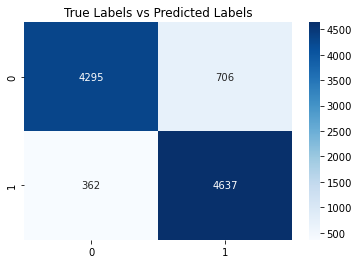

In [122]:
evaluate_model(model, X_test_tfidf_svd, y_test)

In [123]:
def test_joke(joke, model, tfidf, svd):
    arr = [joke]
    test_df = np.array(arr)
    test_df_preprocessed = preprocess_test(tfidf, svd, test_df)
    pred = model.predict(test_df_preprocessed)
    if(pred[0] > 0):
        print("You are funny!")
    else:
        print("Not a joke.")
    return pred[0]

# Examples

In [124]:
test_joke("You were injured in a car crash resulting in multiple injuries", model, tfidf, svd)

Not a joke.


-1.0

In [125]:
test_joke("You are thicker than a bowl of oatmeal", model, tfidf, svd)

You are funny!


1.0